In [19]:
import warnings
import itertools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Load dataset

In [12]:
df_betting = pd.read_csv('../dataset/TAB_Betting_Data_cleaned.csv').drop(columns=['Unnamed: 0'])

In [3]:
df_betting.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,DAY_OF_WEEK_FULL,GENDER_FULL
0,2021-01-01,Fri,13154,67.0,65+,M,11846,WA,37.0,0.0,1081.0,0.0,1118.0,443.55,271.254275,288,Friday,Male
1,2021-01-01,Fri,18379,54.0,45-54,M,1884,WA,40.0,0.0,0.0,0.0,40.0,0.00,40.000000,1,Friday,Male
2,2021-01-01,Fri,559232,63.0,55-64,M,2866,WA,0.0,0.0,12.0,0.0,12.0,9.50,2.041720,5,Friday,Male
3,2021-01-01,Fri,698904,69.0,65+,M,2100,WA,0.0,0.0,1223.5,0.0,1223.5,267.91,245.117147,40,Friday,Male
4,2021-01-01,Fri,762921,67.0,65+,M,4766,WA,0.0,0.0,17.5,0.0,17.5,0.00,3.504075,5,Friday,Male


In [13]:
df_betting['DATE_DIM'] = pd.to_datetime(df_betting['DATE_DIM'])

In [5]:
# created series with total turnover sum by month
y_month=pd.Series(df_betting.groupby(df_betting['DATE_DIM'].dt.to_period('M'))['TOTAL_TURNOVER'].sum())
y_month.head()

DATE_DIM
2021-01    89212215.75
2021-02    83292802.86
2021-03    88291555.21
2021-04    88701156.00
2021-05    87824171.73
Freq: M, Name: TOTAL_TURNOVER, dtype: float64

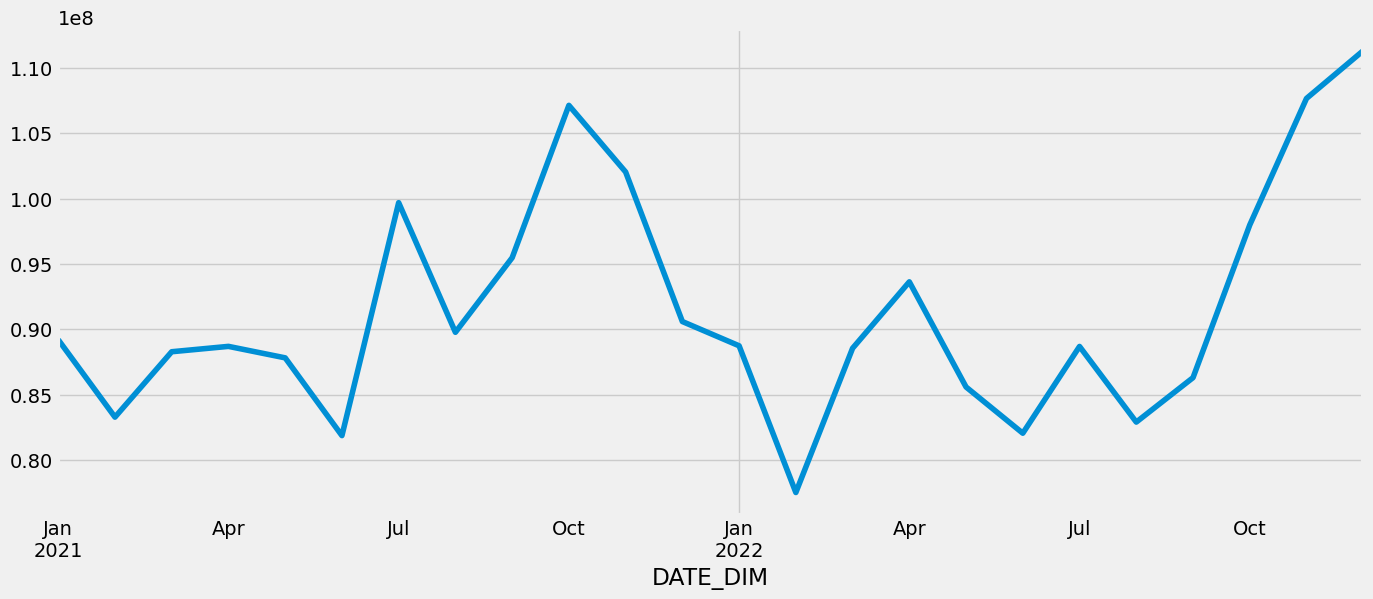

In [6]:
y_month.plot(figsize=(15, 6))
plt.show()

In [7]:
# created series with total turnover sum by datetime
y=pd.Series(df_betting.groupby('DATE_DIM')['TOTAL_TURNOVER'].sum())
y.head()

DATE_DIM
2021-01-01    3835763.01
2021-01-02    6165935.03
2021-01-03    2198013.19
2021-01-04    1523612.17
2021-01-05    1480832.82
Name: TOTAL_TURNOVER, dtype: float64

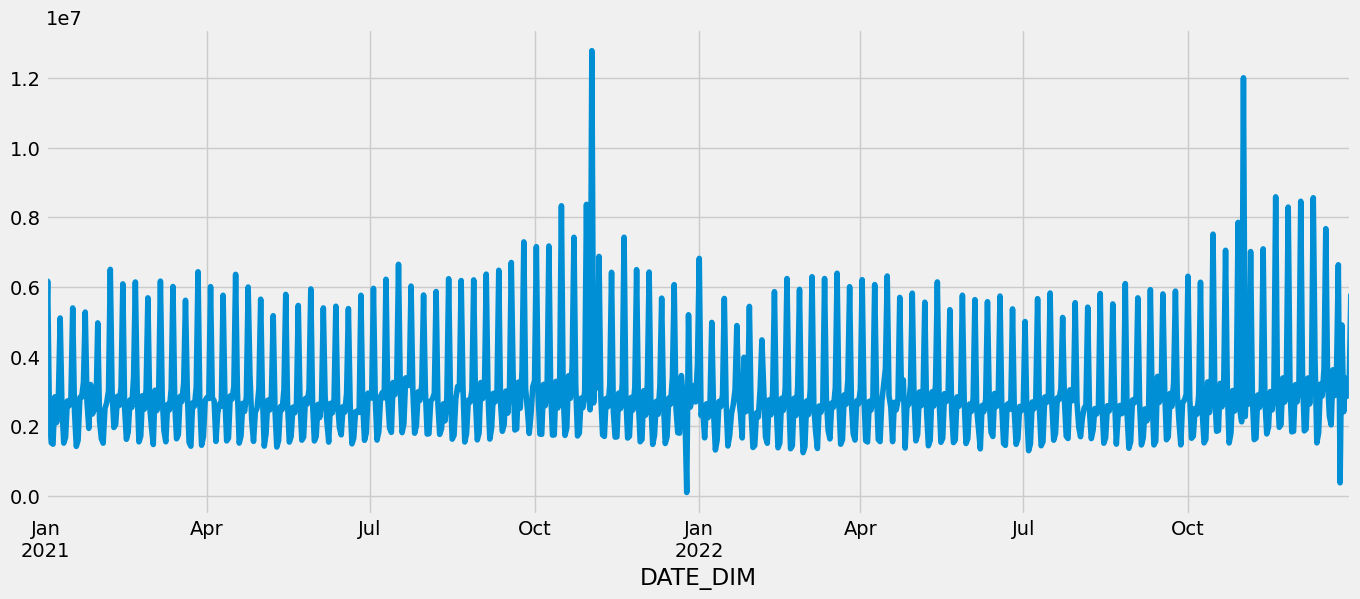

In [8]:
y.plot(figsize=(15, 6))
plt.show()

Nhìn vào biểu đồ trên có thể thấy rằng thời gian có tổng số tiền đặt cược lớn nhất thường rơi vào khoảng cuối năm, giữa tháng 10 đến cuối năm. Còn các tháng còn lại tổng số lượng tiền đặt cược duy trì ở mức ổn định, thấp nhất là vào đầu năm từ tháng 1 đến tháng 2.

# ARIMA Model

Link tham khảo:

[Forcasting with ARIMA model](https://online.stat.psu.edu/stat510/lesson/3/3.3)

[Time series forcasting](https://www.analyticsvidhya.com/blog/2020/10/how-to-create-an-arima-model-for-time-series-forecasting-in-python/)

[Deploying model on tableau](https://github.com/raffg/air-passengers-arima)

## Grid search the p, d, q parameters

#### Define parameters
- p: Số lượng quan sát độ trễ có trong mô hình, còn được gọi là thứ tự độ trễ
- d: Số lần các quan sát thô khác nhau, còn được gọi là mức độ khác biệt
- q: Kích thước của cửa sổ trung bình động, còn được gọi là thứ tự của đường trung bình động.

Khi sử dụng mô hình ARIMA để forcasting, cần xác định xem dữ liệu có cố định(stationary) hay không cố định(non – stationary)
Vậy thì tính cố định(Stationarity) có ảnh hưởng như thế nào đến mô hình: một dữ liệu chuỗi thời gian dừng(stationary time series data) là một trong những tính chất không phụ thuộc vào thời gian. Do đó, chuỗi thời gian với xu hướng, hoặc có tính thời vụ thường không có tính cố định. Xu hướng và tính thời vụ sẽ ảnh hưởng giá trị của chuỗi thời gian tại từ thời điểm khác nhau. Mặt khác với tính cố định sẽ không thay đổi khi bạn quan sát dữ liệu đó.
Mô hình ARIMA sử dụng các chuỗi thời gian dừng sẽ không có những mô hình có thể dự đoán được trong dài hạn. Thường sẽ sử dụng để dự đoán trong ngắn hạn.
Đề xác định bản chất của dữ liệu, sẽ sử dụng giả thiết null

- H0: Giả định null: Đó là một tuyên bố về phân bố được cho là đúng hoặc được sử dụng để đưa ra một lập luận trừ khi nó có thể được chứng minh là sai nếu không có sự nghi ngờ hợp lý.
- H1: Giả định thay thế: Đó là một tuyên bố về phân bố mà được cho là mâu thuẫn với giả định H0 và sẽ là những kết luận khi chúng ta bác bỏ H0

Trong trường hợp này: H0 là dữ liệu không có tính cố định, H1 là dữ liệu có tính cố định.

In [9]:
df_betting_datetime=df_betting.groupby('DATE_DIM')['TOTAL_TURNOVER'].sum().reset_index()
df_betting_datetime.head()

,DATE_DIM,TOTAL_TURNOVER
0,2021-01-01,3835763.01
1,2021-01-02,6165935.03
2,2021-01-03,2198013.19
3,2021-01-04,1523612.17
4,2021-01-05,1480832.82


In [10]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary")

In [11]:
adfuller_test(df_betting_datetime['TOTAL_TURNOVER'])

ADF Test Statistic : -2.7586141272846363
p-value : 0.06443293658201817
#Lags Used : 20
Number of Observations : 709
weak evidence against null hypothesis,indicating it is non-stationary


In [12]:
# first difference and seasonal difference
df_betting_datetime['Sales First Difference'] = df_betting_datetime['TOTAL_TURNOVER'] - df_betting_datetime['TOTAL_TURNOVER'].shift(1)
df_betting_datetime['Seasonal First Difference'] = df_betting_datetime['TOTAL_TURNOVER'] - df_betting_datetime['TOTAL_TURNOVER'].shift(12)

In [13]:
df_betting_datetime

,DATE_DIM,TOTAL_TURNOVER,Sales First Difference,Seasonal First Difference
0,2021-01-01,3835763.01,NaN,NaN
1,2021-01-02,6165935.03,2330172.02,NaN
2,2021-01-03,2198013.19,-3967921.84,NaN
3,2021-01-04,1523612.17,-674401.02,NaN
4,2021-01-05,1480832.82,-42779.35,NaN
...,...,...,...,...
725,2022-12-27,2413850.20,-2494050.91,-452700.26
726,2022-12-28,3379823.57,965973.37,-266968.81
727,2022-12-29,2862803.99,-517019.58,-4811930.27
728,2022-12-30,3000204.42,137400.43,-324723.91


In [14]:
# Again testing if data is stationary
adfuller_test(df_betting_datetime['Seasonal First Difference'].dropna())

ADF Test Statistic : -5.666716223226502
p-value : 9.116207990747258e-07
#Lags Used : 20
Number of Observations : 697
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

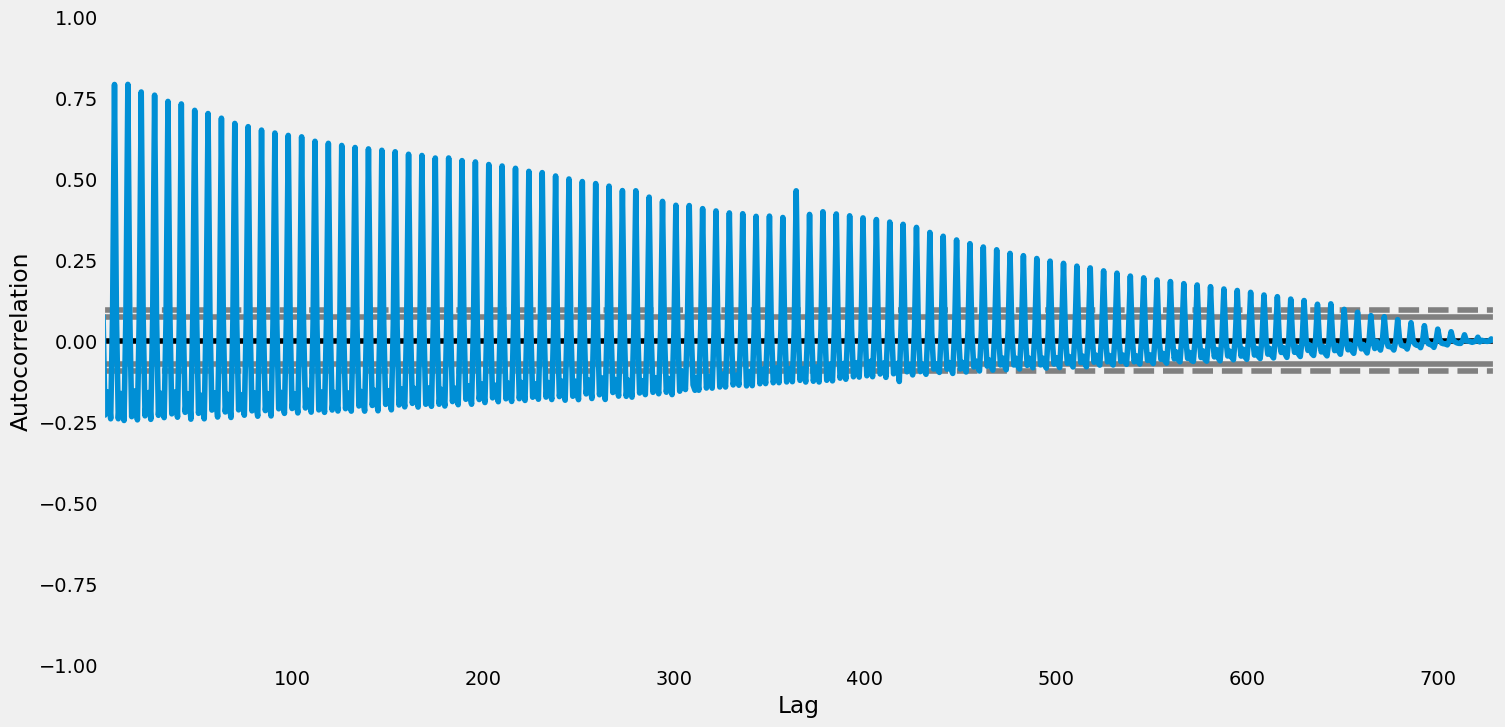

In [16]:
fig = plt.figure(figsize=(16,8))
autocorrelation_plot(y)

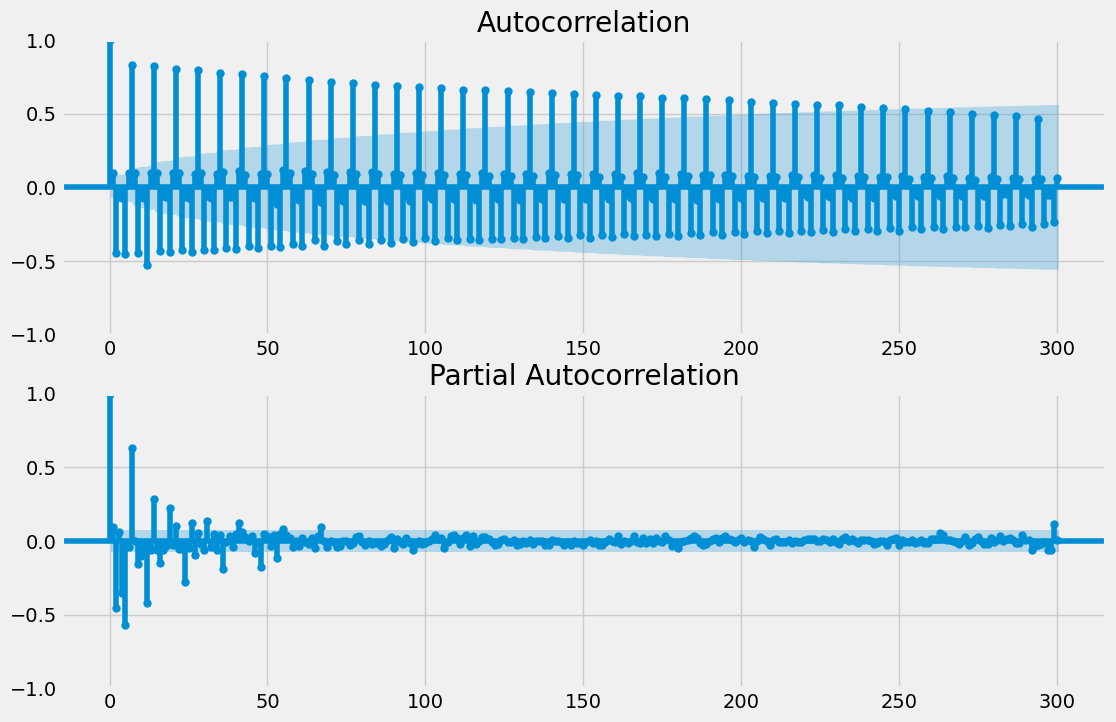

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_betting_datetime['Seasonal First Difference'].dropna(),lags=300,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_betting_datetime['Seasonal First Difference'].dropna(),lags=300,ax=ax2)

In [17]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 5)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [18]:
warnings.filterwarnings("ignore")

best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))

            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
            
print('\nBest Result:', best_result)

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC: 23988.492684720222
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC: 23360.415808844904
ARIMA(0, 0, 0) x (0, 0, 2, 12) - AIC: 22905.448542752973
ARIMA(0, 0, 0) x (0, 0, 3, 12) - AIC: 22399.72937653032
ARIMA(0, 0, 0) x (0, 0, 4, 12) - AIC: 21988.84097720891
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC: 23125.79682975057
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC: 22363.564411995692
ARIMA(0, 0, 0) x (0, 1, 2, 12) - AIC: 21952.530770308753
ARIMA(0, 0, 0) x (0, 1, 3, 12) - AIC: 21562.31866445365
ARIMA(0, 0, 0) x (0, 1, 4, 12) - AIC: 21182.52695724593
ARIMA(0, 0, 0) x (0, 2, 0, 12) - AIC: 23528.638659477085
ARIMA(0, 0, 0) x (0, 2, 1, 12) - AIC: 22627.69905280644
ARIMA(0, 0, 0) x (0, 2, 2, 12) - AIC: 22123.983345168308
ARIMA(0, 0, 0) x (0, 2, 3, 12) - AIC: 21725.675003037795
ARIMA(0, 0, 0) x (0, 2, 4, 12) - AIC: 21338.464762828247
ARIMA(0, 0, 0) x (0, 3, 0, 12) - AIC: 91736728.98722136
ARIMA(0, 0, 0) x (0, 3, 1, 12) - AIC: 91736157.14319968
ARIMA(0, 0, 0) x (0, 3, 2, 12) - AIC: 9

In [ ]:
best_result

In [17]:
model=sm.tsa.arima.ARIMA(df_betting_datetime['TOTAL_TURNOVER'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         TOTAL_TURNOVER   No. Observations:                  730
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11440.233
Date:                Sat, 30 Mar 2024   AIC                          22886.466
Time:                        00:48:54   BIC                          22900.241
Sample:                             0   HQIC                         22891.781
                                - 730                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0754      0.092      0.819      0.413      -0.105       0.256
ma.L1         -0.9893      0.009   -111.034      0.000      -1.007      -0.972
sigma2      3.307e+12   9.36e-15   3.53e+26      0.000    3.31e+12    3.31e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              1151.79
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                             1.94
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.34e+41. Standard errors may be unstable.
"""

In [20]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(best_result[0][0], best_result[0][1], best_result[0][1]),
                                seasonal_order=(best_result[1][0], best_result[1][1], best_result[1][2], best_result[1][3]),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary())
print(results.summary().tables[1])

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                       TOTAL_TURNOVER   No. Observations:                  730
Model:             SARIMAX(2, 0, 0)x(2, 1, [1], 12)   Log Likelihood              -10920.111
Date:                              Sat, 30 Mar 2024   AIC                          21852.221
Time:                                      00:49:18   BIC                          21879.459
Sample:                                  01-01-2021   HQIC                         21862.756
                                       - 12-31-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1983      0.098     -2.020      0.043      -0.391      -0.006
ar.L2         -0.21

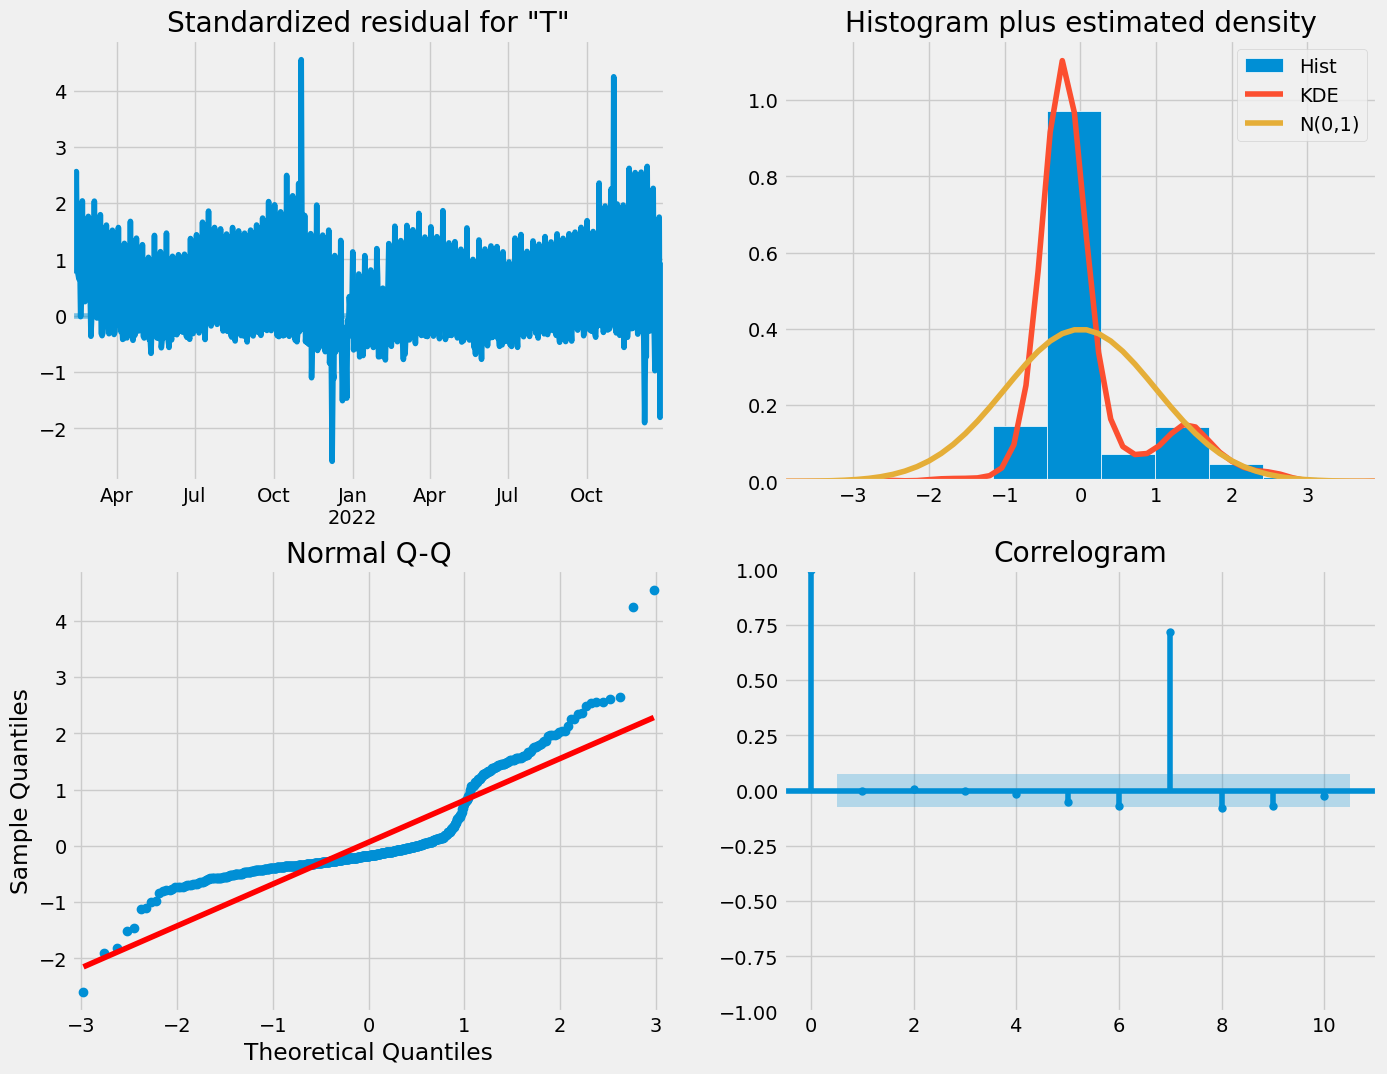

In [21]:
results.plot_diagnostics(figsize=(15, 12))

In [62]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [ ]:
ax = y['1949':].plot(label='Observed', figsize=(15, 12))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')

plt.legend()
plt.show()

In [22]:
pred = results.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_ci = pred.conf_int()

In [23]:
pred_ci

,lower TOTAL_TURNOVER,upper TOTAL_TURNOVER
2021-01-01,-2.771808e+03,2.771808e+03
2021-01-02,-4.603393e+06,3.842644e+06
2021-01-03,-5.852602e+06,2.593435e+06
2021-01-04,-5.966451e+06,2.479587e+06
2021-01-05,-4.991290e+06,3.454747e+06
...,...,...
2022-12-27,-1.447696e+06,6.998339e+06
2022-12-28,-1.671185e+06,6.774851e+06
2022-12-29,-9.301533e+05,7.515882e+06
2022-12-30,-3.801237e+05,8.065912e+06


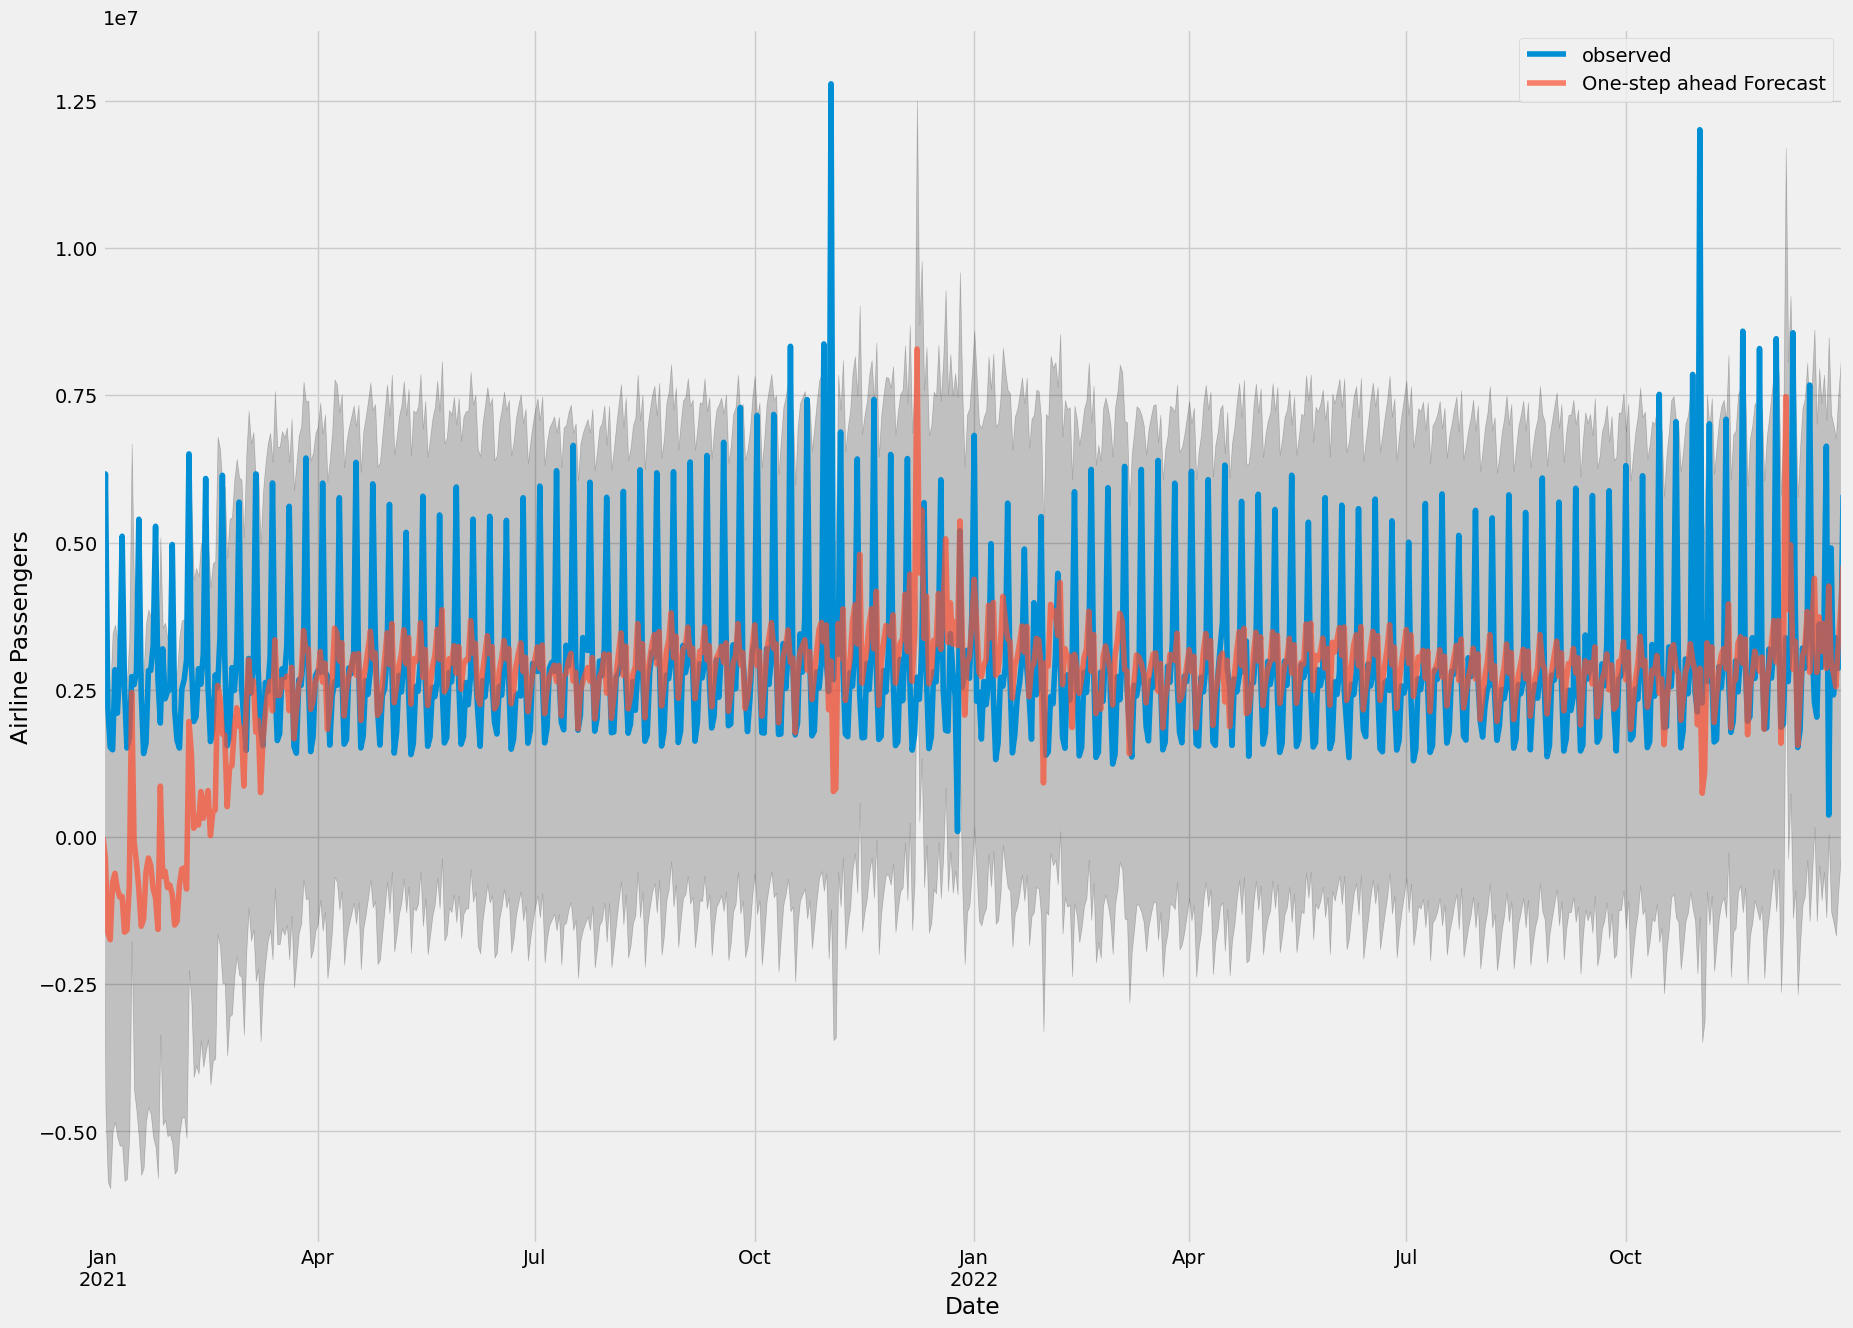

In [24]:
ax = y['2021':].plot(label='observed', figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')
plt.legend()

plt.show()

In [23]:
df_month = pd.read_csv('../dataset/Total_Turnover_month.csv')

In [3]:
df_month.columns

Index(['TOTAL_TURNOVER', 'DATE_DIM'], dtype='object')

In [24]:
df_month['DATE_DIM'] = pd.to_datetime(df_month['DATE_DIM'],infer_datetime_format=True)
df_month = df_month.set_index(['DATE_DIM'])

In [26]:
y = pd.Series(df_month['TOTAL_TURNOVER'], index=df_month.index)

In [5]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_month['TOTAL_TURNOVER'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -4.100845
p-value                         0.000965
#Lags Used                      9.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64


In [28]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 5)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 9) for x in list(itertools.product(p, d, q))]

In [29]:
warnings.filterwarnings("ignore")

best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))

            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
            
print('\nBest Result:', best_result)

ARIMA(0, 0, 0) x (0, 0, 0, 9) - AIC: 910.8332627050081
ARIMA(0, 0, 0) x (0, 0, 1, 9) - AIC: 1021.684742033964
ARIMA(0, 0, 0) x (0, 0, 2, 9) - AIC: 178.47488042029482
ARIMA(0, 0, 0) x (0, 0, 3, 9) - AIC: 8.0
ARIMA(0, 0, 0) x (0, 0, 4, 9) - AIC: 10.0
ARIMA(0, 0, 0) x (0, 1, 0, 9) - AIC: 502.9940873765788
ARIMA(0, 0, 0) x (0, 1, 1, 9) - AIC: 179.9219549282553
ARIMA(0, 0, 0) x (0, 1, 2, 9) - AIC: 6.0
ARIMA(0, 0, 0) x (0, 1, 3, 9) - AIC: 8.0
ARIMA(0, 0, 0) x (0, 1, 4, 9) - AIC: 10.0
ARIMA(0, 0, 0) x (0, 2, 0, 9) - AIC: 196.00646455653302
ARIMA(0, 0, 0) x (0, 2, 1, 9) - AIC: 4.0
ARIMA(0, 0, 0) x (0, 2, 2, 9) - AIC: 6.0
ARIMA(0, 0, 0) x (0, 2, 3, 9) - AIC: 8.0
ARIMA(0, 0, 0) x (0, 2, 4, 9) - AIC: 10.0
ARIMA(0, 0, 0) x (0, 3, 0, 9) - AIC: 2.0
ARIMA(0, 0, 0) x (0, 3, 1, 9) - AIC: 4.0
ARIMA(0, 0, 0) x (0, 3, 2, 9) - AIC: 6.0
ARIMA(0, 0, 0) x (0, 3, 3, 9) - AIC: 8.0
ARIMA(0, 0, 0) x (0, 3, 4, 9) - AIC: 10.0
ARIMA(0, 0, 0) x (0, 4, 0, 9) - AIC: 2.0
ARIMA(0, 0, 0) x (0, 4, 1, 9) - AIC: 4.0
ARIMA(0,

In [ ]:
best_result #[(0, 0, 0), (0, 3, 0, 9), 2.0]